In [1]:
import os
os.environ["FIFT_GL2D_DIR"] = "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"

import time
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from fift import (
    SIS,
    set_num_threads,
    FresnelHankelAxisymmetric,
    FresnelHankelAxisymmetricTrapezoidal,
    FresnelHankelAxisymmetricSciPy,
)
from fift.compare_utils import plot_overlays_ws

from glow import lenses as glow_lenses
from glow import time_domain_c, freq_domain_c

def check_precomputed_gl1d_files(n_gl, Umax, directory):
    """
    Check that the 1D Gauss–Legendre nodes/weights precomputed for (n_gl, Umax)
    exist in `directory`.

    We expect files:
        gl2d_n{n_gl}_U{int(Umax)}.x.npy
        gl2d_n{n_gl}_U{int(Umax)}.w.npy
    """
    if not directory:
        raise RuntimeError("FIFT_GL2D_DIR is not set.")

    base = f"gl2d_n{int(n_gl)}_U{int(Umax)}"
    required = [
        f"{base}.x.npy",
        f"{base}.w.npy",
    ]
    missing = []
    for fname in required:
        path = pathlib.Path(directory, fname)
        if not path.exists():
            missing.append(str(path))

    if missing:
        raise FileNotFoundError(
            "Missing precomputed GL1D files:\n  " + "\n  ".join(missing)
        )
    else:
        print(f"Found precomputed GL1D files for n_gl={n_gl}, Umax={Umax} in {directory}")


def compare_plot_GLoW_FIFT_Hankel(
    n=1024,
    Umax=50.0,
    tol=1e-12,
    lens=SIS(psi0=1.0),
    w_grid=np.logspace(-1.0, 1.0, 50),
    y_star=1.2,
    quadr='GL',
    fht_method='julia_fasthankel',   # NEW (default keeps old behavior)
):

    gl_dir = os.environ.get("FIFT_GL2D_DIR")
    check_precomputed_gl1d_files(n, Umax, gl_dir)

    t0 = time.perf_counter()
    
    # ---------------- FIFT via Hankel (GL / Uniform) + chosen FHT backend ----------------
    if quadr == 'GL':

        if fht_method == 'scipy':
            # GL-style configuration, SciPy FHT backend
            fresnel_ht = FresnelHankelAxisymmetricSciPy(
                lens,
                n_gl=n,
                Umax=Umax,
                gl_dir=gl_dir,
                tol=tol,
            )
            quadr_title = 'GL+SciPy FHT'

        else:
            # Default: Julia FastHankelTransform backend (current behavior)
            fresnel_ht = FresnelHankelAxisymmetric(
                lens,
                n_gl=n,
                Umax=Umax,
                gl_dir=gl_dir,
                tol=tol,
            )
            quadr_title = 'GL+NUFHT'

    elif quadr == 'Trapezoidal':

        if fht_method == 'scipy':
            # Reuse the SciPy GL-based class here, using the same (n, Umax, gl_dir)
            fresnel_ht = FresnelHankelAxisymmetricSciPy(
                lens,
                n_gl=n,
                Umax=Umax,
                gl_dir=gl_dir,
                tol=tol,
            )
            quadr_title = 'Uniform+SciPy FHT'

        else:
            fresnel_ht = FresnelHankelAxisymmetricTrapezoidal(
                lens,
                n_r=n,
                Umax=Umax,
                tol=tol,
            )
            quadr_title = 'Uniform+NUFHT'

    F_fift = fresnel_ht(w_grid, np.array([y_star]))[:, 0]
    t1 = time.perf_counter()
    fift_s = t1 - t0

    # ---------------- GLoW for comparison ----------------
    t2 = time.perf_counter()
    Psi = glow_lenses.Psi_SIS({'psi0': 1.0}, {})
    
    It  = time_domain_c.It_SingleIntegral_C(Psi, y=y_star)
    Fw  = freq_domain_c.Fw_FFT_C(It)

    F_glow = Fw(w_grid)
    t3 = time.perf_counter()
    glow_s = t3 - t2

    # ---------------- Plot and summary ----------------
    plot_overlays_ws(
        w_grid,
        F_fift,
        F_glow,
        n, Umax,
        title=f"SIS ({quadr_title}) @ y={y_star}",
        align_phase=True,
    )

    print(f"FIFT ({quadr_title}) time (single run): {fift_s:.4f} s")
    print(f"GLoW time (single run):                  {glow_s:.4f} s")
    print(f"Speedup (GLoW/FIFT-Hankel):              {glow_s / fift_s:.2f}×")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Gauss-Legendre quadrature + Julia NUFHT

Found precomputed GL1D files for n_gl=8000, Umax=70.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d

────────────────────────────────────────────────────────────
 FresnelHankelAxisymmetric (GL_precomputed + Julia NUFHT)
────────────────────────────────────────────────────────────
  CPU usage summary avg 0.79 cores over 11.428s (0.7% of 112 logical cores; CPU sec=8.974)

  Step 0: Setup / allocations
  ───────────────────────────
    0a. jy (Julia) + F, quad_phase   :   0.00%  (  0.000184 s)

  Step 1: Coefficient Computation (Python)
  ───────────────────────────────────────
    1a. allocate c_re/c_im           :   0.34%  (  0.000042 s)
    1b. coefficient loop (total)     :  99.66%  (  0.012401 s)
        ├─ scale u/w (all w)         :   2.45%  (  0.000305 s)
        ├─ lens potential ψ(u/w)     :  17.00%  (  0.002115 s)
        ├─ phase calculation         :   6.23%  (  0.000775 s)
        ├─ exp(i·phase)              :  59.69%  (  0.007427 s)
        ├─ mu

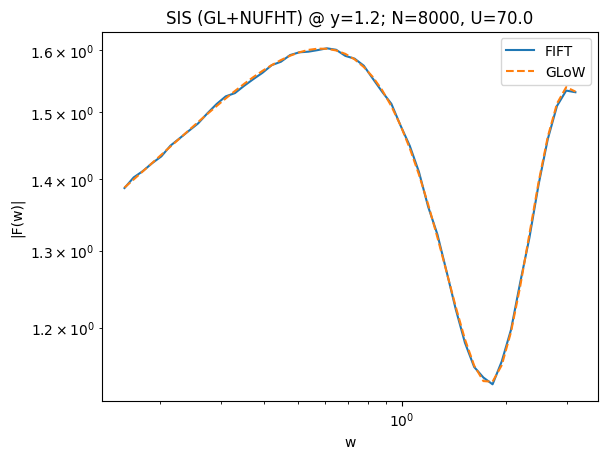

FIFT (GL+NUFHT) time (single run): 14.2905 s
GLoW time (single run):                  0.1108 s
Speedup (GLoW/FIFT-Hankel):              0.01×


In [2]:
compare_plot_GLoW_FIFT_Hankel(
    n=8000,
    Umax=70.0,
    tol=1e-13,
    y_star=1.2,
    w_grid=np.logspace(-0.8, 0.5, 50),
    quadr='GL',
    fht_method='julia_fasthankel',
)

Found precomputed GL1D files for n_gl=8000, Umax=180.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d

────────────────────────────────────────────────────────────
 FresnelHankelAxisymmetric (GL_precomputed + Julia NUFHT)
────────────────────────────────────────────────────────────
  CPU usage summary avg 0.23 cores over 3.157s (0.2% of 112 logical cores; CPU sec=0.719)

  Step 0: Setup / allocations
  ───────────────────────────
    0a. jy (Julia) + F, quad_phase   :   0.00%  (  0.000061 s)

  Step 1: Coefficient Computation (Python)
  ───────────────────────────────────────
    1a. allocate c_re/c_im           :   0.20%  (  0.000028 s)
    1b. coefficient loop (total)     :  99.80%  (  0.014104 s)
        ├─ scale u/w (all w)         :   2.54%  (  0.000359 s)
        ├─ lens potential ψ(u/w)     :  10.20%  (  0.001441 s)
        ├─ phase calculation         :   6.77%  (  0.000956 s)
        ├─ exp(i·phase)              :  64.01%  (  0.009046 s)
        ├─ mu

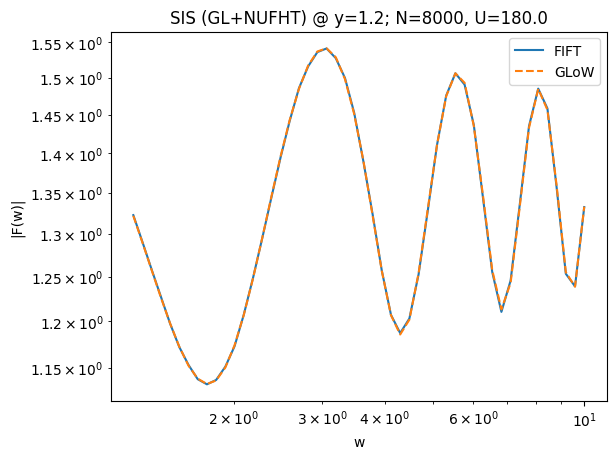

FIFT (GL+NUFHT) time (single run): 3.1621 s
GLoW time (single run):                  0.0346 s
Speedup (GLoW/FIFT-Hankel):              0.01×


In [3]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=180.0, tol=1e-13,
                              y_star=1.2, w_grid=np.logspace(0.1, 1.0, 50),
                              quadr='GL',
                              fht_method='julia_fasthankel',)

## SciPy's FHT

Found precomputed GL1D files for n_gl=8000, Umax=15.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d

────────────────────────────────────────────────────────────
 FresnelHankelAxisymmetricSciPy Timing
────────────────────────────────────────────────────────────
  CPU usage summary avg 1.04 cores over 0.029s (0.9% of 112 logical cores; CPU sec=0.030)

  Step 1: Coefficient build (Python + NumPy)
  ───────────────────────────────────────────
    1a. Alloc a_re/a_im              :   0.38%  (  0.000047 s)
    1b. Coefficient loop (all w)     :  98.67%  (  0.012239 s)

    Step 1 total                     :  42.48%  (  0.012404 s)

  Step 2: SciPy fast Hankel transform (FFTLog)
  ────────────────────────────────────────────
    2a. fht(a_re) + fht(a_im)        :  35.70%  (  0.010424 s)

    Step 2 total                     :  35.70%  (  0.010425 s)

  Step 3: Post-processing and interpolation
  ──────────────────────────────────────────
    3a. sort k, logk       

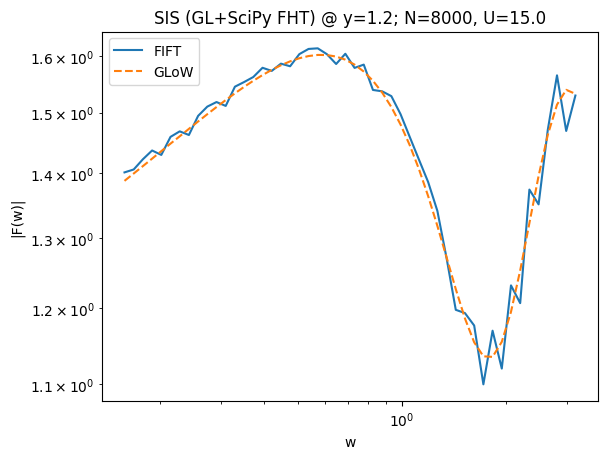

FIFT (GL+SciPy FHT) time (single run): 0.0345 s
GLoW time (single run):                  0.0088 s
Speedup (GLoW/FIFT-Hankel):              0.26×


In [4]:
compare_plot_GLoW_FIFT_Hankel(
    n=8000,
    Umax=15.0,
    tol=1e-13,
    y_star=1.2,
    w_grid=np.logspace(-0.8, 0.5, 50),
    quadr='GL',
    fht_method='scipy',
)

Found precomputed GL1D files for n_gl=8000, Umax=70.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d

────────────────────────────────────────────────────────────
 FresnelHankelAxisymmetricSciPy Timing
────────────────────────────────────────────────────────────
  CPU usage summary avg 1.03 cores over 0.025s (0.9% of 112 logical cores; CPU sec=0.026)

  Step 1: Coefficient build (Python + NumPy)
  ───────────────────────────────────────────
    1a. Alloc a_re/a_im              :   0.24%  (  0.000025 s)
    1b. Coefficient loop (all w)     :  98.99%  (  0.010444 s)

    Step 1 total                     :  41.78%  (  0.010551 s)

  Step 2: SciPy fast Hankel transform (FFTLog)
  ────────────────────────────────────────────
    2a. fht(a_re) + fht(a_im)        :  37.00%  (  0.009345 s)

    Step 2 total                     :  37.00%  (  0.009345 s)

  Step 3: Post-processing and interpolation
  ──────────────────────────────────────────
    3a. sort k, logk       

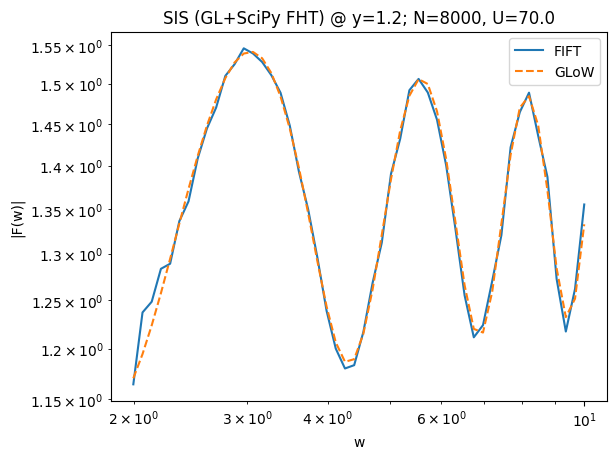

FIFT (GL+SciPy FHT) time (single run): 0.0300 s
GLoW time (single run):                  0.0074 s
Speedup (GLoW/FIFT-Hankel):              0.25×


In [5]:
compare_plot_GLoW_FIFT_Hankel(
    n=8000,
    Umax=70.0,
    tol=1e-13,
    y_star=1.2,
    w_grid=np.logspace(0.3, 1., 50),
    quadr='GL',
    fht_method='scipy',
)

## Trapezoidal quadrature + Julia NUFHT

Found precomputed GL1D files for n_gl=8000, Umax=70.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d

────────────────────────────────────────────────────────────
 FresnelHankelAxisymmetric (Trapezoidal + Julia NUFHT)
────────────────────────────────────────────────────────────
  CPU usage summary avg 0.25 cores over 3.302s (0.2% of 112 logical cores; CPU sec=0.825)

  Step 1: Coefficient Computation (Python + NumPy)
  ────────────────────────────────────────────────
    1a. list setup/alloc (all_c_*)   :   0.00%  (  0.000000 s)
    1b. coefficient loop (total)     :  85.66%  (  0.025778 s)
        ├─ scale u/w (all w)         :   1.83%  (  0.000551 s)
        ├─ lens potential ψ(u/w)     :   6.14%  (  0.001849 s)
        ├─ phase calculation         :  10.64%  (  0.003202 s)
        ├─ exp(i·phase)              :  61.20%  (  0.018418 s)
        ├─ multiply by u_k Δu_k      :   3.08%  (  0.000927 s)
        └─ unaccounted (loop)        :   2.76%  (  0.000830 s

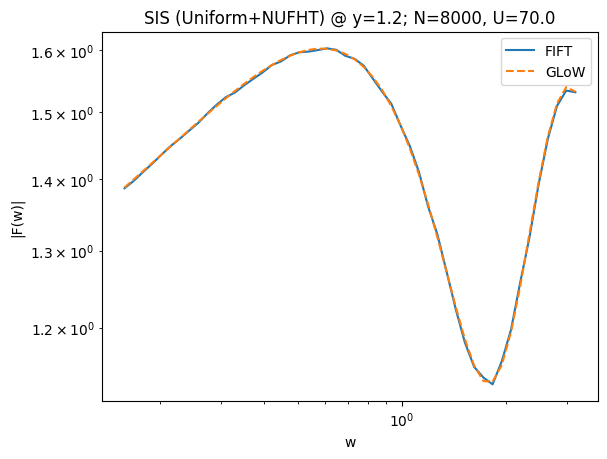

FIFT (Uniform+NUFHT) time (single run): 3.3041 s
GLoW time (single run):                  0.0126 s
Speedup (GLoW/FIFT-Hankel):              0.00×


In [6]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=70.0, tol=1e-13, y_star=1.2,
                              w_grid=np.logspace(-0.8, 0.5, 50),
                              quadr='Trapezoidal')

Found precomputed GL1D files for n_gl=8000, Umax=180.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d

────────────────────────────────────────────────────────────
 FresnelHankelAxisymmetric (Trapezoidal + Julia NUFHT)
────────────────────────────────────────────────────────────
  CPU usage summary avg 0.24 cores over 3.225s (0.2% of 112 logical cores; CPU sec=0.784)

  Step 1: Coefficient Computation (Python + NumPy)
  ────────────────────────────────────────────────
    1a. list setup/alloc (all_c_*)   :   0.00%  (  0.000000 s)
    1b. coefficient loop (total)     :  82.42%  (  0.030419 s)
        ├─ scale u/w (all w)         :   2.03%  (  0.000749 s)
        ├─ lens potential ψ(u/w)     :   6.04%  (  0.002228 s)
        ├─ phase calculation         :   7.33%  (  0.002704 s)
        ├─ exp(i·phase)              :  59.51%  (  0.021966 s)
        ├─ multiply by u_k Δu_k      :   4.60%  (  0.001699 s)
        └─ unaccounted (loop)        :   2.91%  (  0.001074 

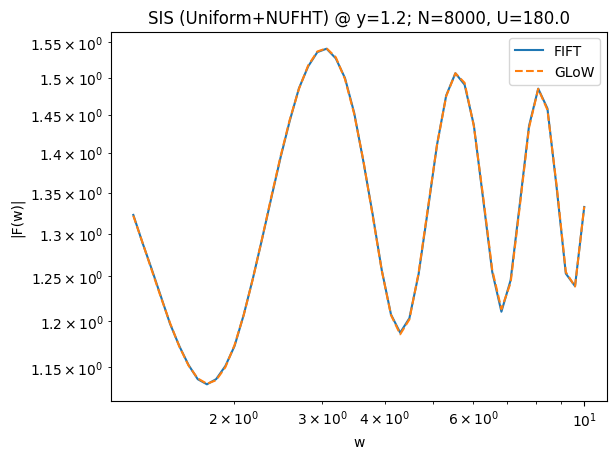

FIFT (Uniform+NUFHT) time (single run): 3.2270 s
GLoW time (single run):                  0.0109 s
Speedup (GLoW/FIFT-Hankel):              0.00×


In [7]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=180.0, tol=1e-13,
                              y_star=1.2, w_grid=np.logspace(0.1, 1.0, 50),
                              quadr='Trapezoidal')